# BLATEM

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.svm import SVC,LinearSVC 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from scipy.sparse import csr_matrix
import pickle
import joblib
import glob
import numpy as np
import os
from Bio import SeqIO

In [3]:
'''
amr_folder = "/home/hnakabuye/Desktop/AMR_APP/pos_tem"
nonamr_folder = "/home/hnakabuye/Desktop/AMR_APP/neg_tem"

def load_fasta_folder(folder, label):
    """Load all FASTA files from a folder into a DataFrame with a given label.
    Each file is treated as a single DNA sequence (concatenated if multiple records exist)."""
    all_records = []
    fasta_files = glob.glob(os.path.join(folder, "*.fas"))  # or *.fasta

    for f in fasta_files:
        # Read all records in the file and concatenate their sequences
        sequences = [str(record.seq) for record in SeqIO.parse(f, "fasta")]
        full_sequence = "".join(sequences)  # combine all into one string

        all_records.append({
            "id": os.path.splitext(os.path.basename(f))[0],  # use filename as ID
            "sequence": full_sequence,
            "label": label,
            "source_file": os.path.basename(f)
        })

    return pd.DataFrame(all_records)

# Load all AMR and non-AMR data
amr_data = load_fasta_folder(amr_folder, label=1)
nonamr_data = load_fasta_folder(nonamr_folder, label=0)

# Combine into one DataFrame
data = pd.concat([amr_data, nonamr_data]).reset_index(drop=True)

print(f"Loaded {len(data)} sequences from {len(amr_data)} AMR and {len(nonamr_data)} non-AMR files.")
print(data.head())

print(data.shape)
data.to_csv('tem_data.csv', index=False)
'''

Loaded 139 sequences from 46 AMR and 93 non-AMR files.
     id                                           sequence  label source_file
0  BN19  CACCTGATGATTTTCATCGTATACGCGCTGTATCTCTCTCTTCAGC...      1    BN19.fas
1    57  CCTGCAACGCCTATAAAATCCGCTAAACAGTGCAGGTTGTCGATGA...      1      57.fas
2  BN37  CGCATCCAACATCTAACGCCCGAGCCGGTTGCCTGATGCGACGCTG...      1    BN37.fas
3  BN48  TCTCACGTCCGGTGTGGATAGCGCAGGCGTATCAGCAGCAGATAGC...      1    BN48.fas
4  BN51  GGGTGGCGGGGCGGTGCGTGGTGTTATTGGGAATAGAGGGGCGGGG...      1    BN51.fas
(139, 4)


In [4]:
# Load data
df = pd.read_csv("tem_data.csv")
print(df.head())

# Convert sequences to k-mers (e.g., k=6)
def get_kmers(seq, k=6):
    return " ".join([seq[i:i+k] for i in range(len(seq) - k + 1)])

df['kmers'] = df['sequence'].apply(get_kmers)

# Vectorize k-mers
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['kmers'])
y = df['label']

     id                                           sequence  label source_file
0  BN19  CACCTGATGATTTTCATCGTATACGCGCTGTATCTCTCTCTTCAGC...      1    BN19.fas
1    57  CCTGCAACGCCTATAAAATCCGCTAAACAGTGCAGGTTGTCGATGA...      1      57.fas
2  BN37  CGCATCCAACATCTAACGCCCGAGCCGGTTGCCTGATGCGACGCTG...      1    BN37.fas
3  BN48  TCTCACGTCCGGTGTGGATAGCGCAGGCGTATCAGCAGCAGATAGC...      1    BN48.fas
4  BN51  GGGTGGCGGGGCGGTGCGTGGTGTTATTGGGAATAGAGGGGCGGGG...      1    BN51.fas


In [5]:
# Split & train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=123)

              precision    recall  f1-score   support

           0       0.71      0.89      0.79        19
           1       0.50      0.22      0.31         9

    accuracy                           0.68        28
   macro avg       0.60      0.56      0.55        28
weighted avg       0.64      0.68      0.64        28



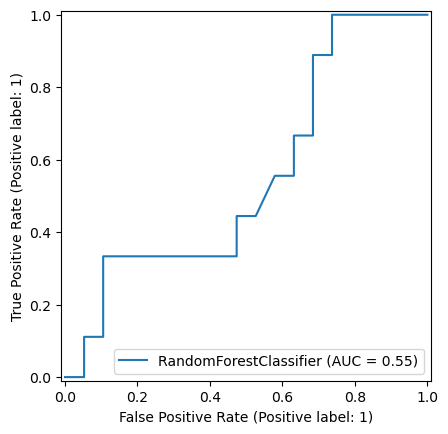

In [7]:
Rmodel = RandomForestClassifier(n_estimators=200, random_state=123)
Rmodel.fit(X_train, y_train)

# Evaluate
y_pred = Rmodel.predict(X_test)
print(classification_report(y_test, y_pred))
RF_disp = RocCurveDisplay.from_estimator(Rmodel, X_test, y_test)

              precision    recall  f1-score   support

           0       0.67      0.74      0.70        19
           1       0.29      0.22      0.25         9

    accuracy                           0.57        28
   macro avg       0.48      0.48      0.47        28
weighted avg       0.54      0.57      0.56        28



/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


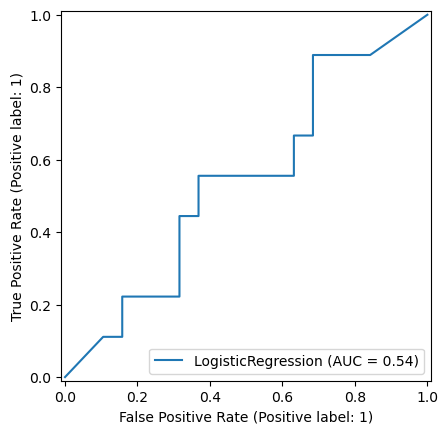

In [8]:
Lmodel = LogisticRegression() 
Lmodel.fit(X_train, y_train)
# Evaluate
y_pred = Lmodel.predict(X_test)
print(classification_report(y_test, y_pred))

LR_disp = RocCurveDisplay.from_estimator(Lmodel, X_test, y_test)

              precision    recall  f1-score   support

           0       0.69      0.95      0.80        19
           1       0.50      0.11      0.18         9

    accuracy                           0.68        28
   macro avg       0.60      0.53      0.49        28
weighted avg       0.63      0.68      0.60        28



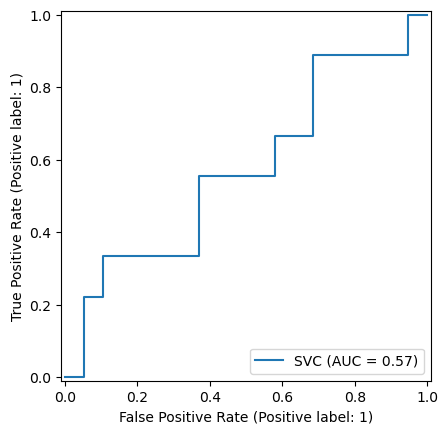

In [9]:
svc = SVC(random_state=123)
svc.fit(X_train, y_train)

# Evaluate
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)

In [10]:
with open('tem_svc.pkl', 'wb') as file:
        pickle.dump(svc, file)

In [11]:
joblib.dump(vectorizer, "kmer_vectorizer.joblib")

['kmer_vectorizer.joblib']